In [1]:
# import all necessary libraries
import time
import warnings
from pathlib import Path

import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import xarray as xr
from joblib import Parallel, delayed
from scipy.interpolate import griddata
from shapely.geometry import Point
from shapely.prepared import prep
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from utils.config import (
    OCEAN_POINTS,
    WEATHER_POINTS,
)
from utils.eda_helper_functions import (
    group_data_hourly,
    load_insitu_data,
    load_ocean_data,
    load_weather_data,
    process_df,
    process_flensburg_data,
)
from utils.ml_helper_functions import (
    convert_to_xarray,
    feature_engineering,
)
from utils.Model_Training import training_ConvLSTM

# Ignore SettingWithCopyWarning:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

# Display all columns
pd.options.display.max_columns = None


plt.rcParams.update({
    "font.size": 14,                # Grundschriftgröße (wirkt auf alles, sofern nicht überschrieben)
    "axes.titlesize": 16,           # Größe des Titels der Achse (z.B. 'Subplot Title')
    "axes.labelsize": 14,           # Achsenbeschriftung (x/y label)
    "xtick.labelsize": 12,          # X-Tick-Beschriftung
    "ytick.labelsize": 12,          # Y-Tick-Beschriftung
    "legend.fontsize": 12,          # Legendentext
    "figure.titlesize": 18,         # Gesamttitel der Abbildung (plt.suptitle)
    "figure.labelsize": 14,         # (optional, selten verwendet)
    "savefig.dpi": 300,             # DPI beim Speichern
    "figure.dpi": 100,              # DPI bei Anzeige
})

OCEAN_POINTS = 30
GRID_SIZE = 25
HORIZON = 168
ocean_data_path = Path(f"../data/numerical_data/points{OCEAN_POINTS}")
print(ocean_data_path)
weather_data_path = Path(f"../data/numerical_data/points{WEATHER_POINTS}")
print(weather_data_path)

../data/numerical_data/points30
../data/numerical_data/points10


In [2]:
ocean_data_path = Path(f"../data/numerical_data/points{OCEAN_POINTS}")
weather_data_path = Path(f"../data/numerical_data/points{WEATHER_POINTS}")

print("\nLoading data from:")
print(ocean_data_path)
print(weather_data_path)

# save df_merged to ../data/tabular_data_FI/
# file_name = f'df_merged{OCEAN_POINTS}_FI.tsv'
# output_path = Path('../data/tabular_data_FI/')

print("\nLoading ocean, weather and insitu data...")
df_ocean = load_ocean_data(ocean_data_path, OCEAN_POINTS, verbose=False)
df_ocean = process_df(df_ocean, drop_cols=["depth"], verbose=False)

df_weather = load_weather_data(weather_data_path, WEATHER_POINTS, verbose=False)
df_weather = process_df(df_weather, verbose=False, drop_cols=['showers'])

df_insitu = load_insitu_data(verbose=False)
df_insitu = process_flensburg_data(df_insitu, 
                                    start_time=df_ocean['time'].min(),
                                    end_time=df_ocean['time'].max(),
                                    verbose=False)

df_insitu = group_data_hourly(df_insitu)
df_insitu = process_df(df_insitu, drop_cols=["depth",'deph', 'latitude', 'longitude', 'time_qc', 'slev_qc'], verbose=False)

print(f"\nShapes of loaded DataFrames before feature engineering:\n"
        f"Ocean DataFrame: {df_ocean.shape}\n"
        f"Weather DataFrame: {df_weather.shape}\n"
        f"Insitu DataFrame: {df_insitu.shape}")

print("\nFeature engineering...")
df_ocean, df_weather, df_insitu = feature_engineering(df_ocean, df_weather, df_insitu)

print(f"\nShapes of loaded DataFrames after feature engineering:\n"
        f"Ocean DataFrame: {df_ocean.shape}\n"
        f"Weather DataFrame: {df_weather.shape}\n"
        f"Insitu DataFrame: {df_insitu.shape}")

# Convert DataFrames to xarray DataArrays
print("\nConverting DataFrames to xarray DataArrays...")
ds_ocean = convert_to_xarray(df_ocean)
ds_weather = convert_to_xarray(df_weather)


Loading data from:
../data/numerical_data/points30
../data/numerical_data/points10

Loading ocean, weather and insitu data...

Shapes of loaded DataFrames before feature engineering:
Ocean DataFrame: (9415187, 14)
Weather DataFrame: (2018400, 22)
Insitu DataFrame: (20161, 2)

Feature engineering...

Shapes of loaded DataFrames after feature engineering:
Ocean DataFrame: (9415187, 11)
Weather DataFrame: (2018400, 8)
Insitu DataFrame: (20161, 2)

Converting DataFrames to xarray DataArrays...


In [3]:
ds_ocean

<xarray.Dataset> Size: 639MB
Dimensions:    (time: 20161, latitude: 33, longitude: 30)
Coordinates:
  * time       (time) datetime64[ns] 161kB 2022-12-03 ... 2025-03-22
  * latitude   (latitude) float32 132B 53.72 53.94 54.17 ... 59.56 59.77 60.01
  * longitude  (longitude) float32 120B 9.097 9.569 10.04 ... 22.04 22.51 22.99
Data variables:
    bottomT    (time, latitude, longitude) float32 80MB nan nan ... nan 1.237
    sla        (time, latitude, longitude) float32 80MB nan nan ... nan -0.1225
    so         (time, latitude, longitude) float32 80MB nan nan ... nan 3.865
    sob        (time, latitude, longitude) float32 80MB nan nan ... nan 4.504
    thetao     (time, latitude, longitude) float32 80MB nan nan nan ... nan 1.52
    uo         (time, latitude, longitude) float32 80MB nan nan ... nan -0.01419
    vo         (time, latitude, longitude) float32 80MB nan nan ... nan 0.01045
    wo         (time, latitude, longitude) float32 80MB nan nan ... 1.011e-08

In [4]:
print(ds_weather)

<xarray.Dataset> Size: 400MB
Dimensions:           (time: 20184, latitude: 10, longitude: 99)
Coordinates:
  * time              (time) datetime64[ns] 161kB 2022-12-03 ... 2025-03-22T2...
  * latitude          (latitude) float32 40B 53.53 54.24 54.94 ... 59.3 60.0
  * longitude         (longitude) float32 396B 8.979 9.12 9.123 ... 23.08 23.1
Data variables:
    pressure_msl      (time, latitude, longitude) float32 80MB nan ... nan
    surface_pressure  (time, latitude, longitude) float32 80MB nan ... nan
    wind_gusts_10m    (time, latitude, longitude) float32 80MB nan 28.8 ... nan
    wind_u            (time, latitude, longitude) float32 80MB nan 14.4 ... nan
    wind_v            (time, latitude, longitude) float32 80MB nan 5.76 ... nan


In [5]:


def interpolate_time_step(da, lon_mesh, lat_mesh):
    # 1. Werte extrahieren
    lon, lat = np.meshgrid(da.longitude, da.latitude)
    lon_flat = lon.flatten()
    lat_flat = lat.flatten()
    values_flat = da.values.flatten()

    # 2. Nur gültige Werte
    mask = ~np.isnan(values_flat)
    if np.count_nonzero(mask) == 0:
        return np.full(lon_mesh.shape, np.nan)  # kein gültiger Punkt

    points = np.column_stack((lon_flat[mask], lat_flat[mask]))
    values = values_flat[mask]

    # 3. Interpolation
    interp_grid = griddata(
        points,
        values,
        (lon_mesh, lat_mesh),
        method="linear"
    )
    return interp_grid

def make_grid_parallel(ds, n_jobs=-1, fill_na=False):
    time = ds.time.values

    # Zielgrid
    lon_target = np.linspace(ds.longitude.min(), ds.longitude.max(), GRID_SIZE)
    lat_target = np.linspace(ds.latitude.min(), ds.latitude.max(), GRID_SIZE)
    lon_mesh, lat_mesh = np.meshgrid(lon_target, lat_target)

    variables_interp = {}

    for var_name in ds.data_vars:
        print(f"Interpolating variable: {var_name}")

        da_var = ds[var_name]

        # Parallelisierung über Zeit
        interpolated_values = Parallel(n_jobs=n_jobs)(
            delayed(interpolate_time_step)(da_var.isel(time=t), lon_mesh, lat_mesh)
            for t in tqdm(range(len(time)))
        )

        # In xarray schreiben
        variables_interp[var_name] = xr.DataArray(
            data=np.array(interpolated_values),
            dims=["time", "latitude", "longitude"],
            coords={
                "time": time,
                "latitude": lat_target,
                "longitude": lon_target
            }
        )

    ds_interp = xr.Dataset(variables_interp)

    if fill_na:
        # Fülle verbleibende NaNs mit 9999
        return ds_interp.fillna(9999)
    return ds_interp

ds_weather_interp = make_grid_parallel(ds_weather)

Interpolating variable: pressure_msl


  0%|          | 0/20184 [00:00<?, ?it/s]

100%|██████████| 20184/20184 [00:11<00:00, 1711.04it/s]


Interpolating variable: surface_pressure


100%|██████████| 20184/20184 [00:03<00:00, 5485.87it/s]


Interpolating variable: wind_gusts_10m


100%|██████████| 20184/20184 [00:03<00:00, 5676.82it/s]


Interpolating variable: wind_u


100%|██████████| 20184/20184 [00:03<00:00, 5787.70it/s]


Interpolating variable: wind_v


100%|██████████| 20184/20184 [00:04<00:00, 4990.50it/s]


In [6]:


def is_ocean(latitudes, longitudes):
    """Gibt eine bool-Maske zurück, wo True = Ozean, False = Land"""
    land = cfeature.NaturalEarthFeature('physical', 'land', '10m')
    geometries = list(land.geometries())
    land_geom = prep(geometries[0])

    mask = np.ones(latitudes.shape, dtype=bool)
    for i in range(latitudes.shape[0]):
        for j in range(latitudes.shape[1]):
            point = Point(longitudes[i, j], latitudes[i, j])
            if land_geom.contains(point):
                mask[i, j] = False  # Land
    return mask

def interpolate_single_timestep(da, lon_mesh, lat_mesh, ocean_mask, t):
    """Interpoliert eine Variable an einem Zeitschritt"""
    frame = da.isel(time=t)
    lon, lat = np.meshgrid(frame.longitude, frame.latitude)
    lon_flat = lon.flatten()
    lat_flat = lat.flatten()
    values_flat = frame.values.flatten()

    mask = ~np.isnan(values_flat)
    if np.count_nonzero(mask) == 0:
        return np.full(lon_mesh.shape, np.nan)

    points = np.column_stack((lon_flat[mask], lat_flat[mask]))
    values = values_flat[mask]

    interp_grid = griddata(points, values, (lon_mesh, lat_mesh), method="linear")

    # Landmaske anwenden
    interp_grid[~ocean_mask] = np.nan
    return interp_grid

def make_grid_ocean_parallel(ds, n_jobs=-1, fill_na=False):
    time = ds.time.values

    # Zielgrid
    lon_target = np.linspace(ds.longitude.min(), ds.longitude.max(), GRID_SIZE)
    lat_target = np.linspace(ds.latitude.min(), ds.latitude.max(), GRID_SIZE)
    lon_mesh, lat_mesh = np.meshgrid(lon_target, lat_target)

    # Landmaske
    ocean_mask = is_ocean(lat_mesh, lon_mesh)

    variables_interp = {}

    for var_name in ds.data_vars:
        print(f"Interpolate: {var_name}")

        da = ds[var_name]

        # Parallelisiere über Zeitachse
        results = Parallel(n_jobs=n_jobs)(
            delayed(interpolate_single_timestep)(da, lon_mesh, lat_mesh, ocean_mask, t)
            for t in tqdm(range(len(time)))
        )

        variables_interp[var_name] = xr.DataArray(
            data=np.array(results),
            dims=["time", "latitude", "longitude"],
            coords={
                "time": time,
                "latitude": lat_target,
                "longitude": lon_target
            }
        )

    if fill_na:
        ds_interp = xr.Dataset(variables_interp).fillna(9999)
    else:
        ds_interp = xr.Dataset(variables_interp)
    return ds_interp
ds_ocean_interp = make_grid_ocean_parallel(ds_ocean)

Interpolate: bottomT


100%|██████████| 20161/20161 [00:02<00:00, 9804.43it/s]


Interpolate: sla


100%|██████████| 20161/20161 [00:02<00:00, 9978.75it/s]


Interpolate: so


100%|██████████| 20161/20161 [00:02<00:00, 9378.08it/s] 


Interpolate: sob


100%|██████████| 20161/20161 [00:02<00:00, 9837.56it/s] 


Interpolate: thetao


100%|██████████| 20161/20161 [00:02<00:00, 8927.05it/s] 


Interpolate: uo


100%|██████████| 20161/20161 [00:02<00:00, 9930.44it/s] 


Interpolate: vo


100%|██████████| 20161/20161 [00:02<00:00, 8895.83it/s]


Interpolate: wo


100%|██████████| 20161/20161 [00:02<00:00, 9786.38it/s] 


In [7]:


def plot_xarray(ds, variable, time_idx=0, cmap='viridis', cbar_label=None):
    """
    Plots a variable from an xarray Dataset for a specific time index.

    Parameters:
    - ds: xarray Dataset
    - variable: str, name of the variable to plot
    - time_idx: int, index of the time step to plot
    - cmap: str, colormap to use for the plot
    - cbar_label: str, label for the colorbar
    """
    data = ds[variable].isel(time=time_idx)

    # 1. Setze 9999 → np.nan, damit sie nicht geplottet werden
    data = data.where(data < 9000)

    # 2. Plotten
    plt.figure(figsize=(8, 5))
    data.plot(
        x='longitude',
        y='latitude',
        cmap=cmap,
        cbar_kwargs={'label': cbar_label}
    )

    plt.title(f"{variable} at {str(ds.time.values[time_idx])[:16]}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()


In [8]:
print("\nOcean DataArray:")
print(ds_ocean_interp)
print("\nWeather DataArray:")
print(ds_weather_interp)


Ocean DataArray:
<xarray.Dataset> Size: 807MB
Dimensions:    (time: 20161, latitude: 25, longitude: 25)
Coordinates:
  * time       (time) datetime64[ns] 161kB 2022-12-03 ... 2025-03-22
  * latitude   (latitude) float64 200B 53.72 53.99 54.25 ... 59.48 59.75 60.01
  * longitude  (longitude) float64 200B 9.097 9.676 10.25 ... 21.83 22.41 22.99
Data variables:
    bottomT    (time, latitude, longitude) float64 101MB nan nan ... 1.409 1.237
    sla        (time, latitude, longitude) float64 101MB nan nan ... -0.1225
    so         (time, latitude, longitude) float64 101MB nan nan ... 5.195 3.865
    sob        (time, latitude, longitude) float64 101MB nan nan ... 5.503 4.504
    thetao     (time, latitude, longitude) float64 101MB nan nan ... 1.672 1.52
    uo         (time, latitude, longitude) float64 101MB nan nan ... -0.01419
    vo         (time, latitude, longitude) float64 101MB nan nan ... 0.01045
    wo         (time, latitude, longitude) float64 101MB nan nan ... 1.011e-08

Wea

In [9]:


# 1. Zielgitter vom Ozean-Dataset
time_target = ds_ocean_interp.time
lat_target = ds_ocean_interp.latitude
lon_target = ds_ocean_interp.longitude

# 2. Wetterdaten auf das Ocean-Gitter interpolieren
ds_weather_interp_resampled = ds_weather_interp.interp(
    time=time_target,
    latitude=lat_target,
    longitude=lon_target,
    method="linear"
)

# 3. Merge beider Datasets auf dem gemeinsamen Gitter
ds_combined = xr.merge([ds_ocean_interp, ds_weather_interp_resampled])

# 4. Füllwerte angleichen
ds_combined = ds_combined.where(ds_combined < 9000).fillna(9999)


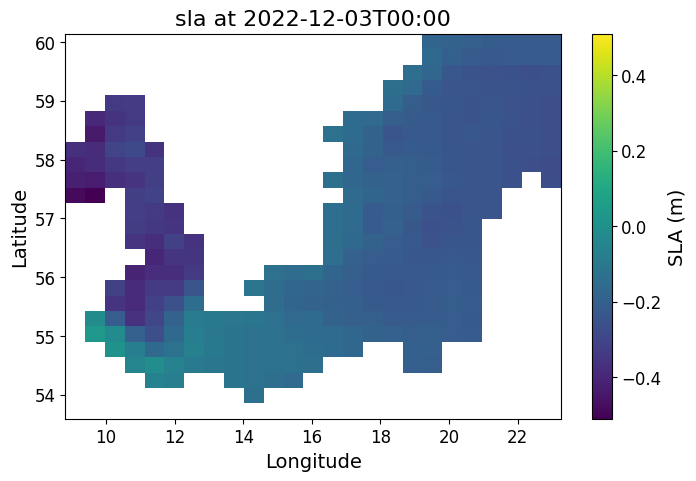

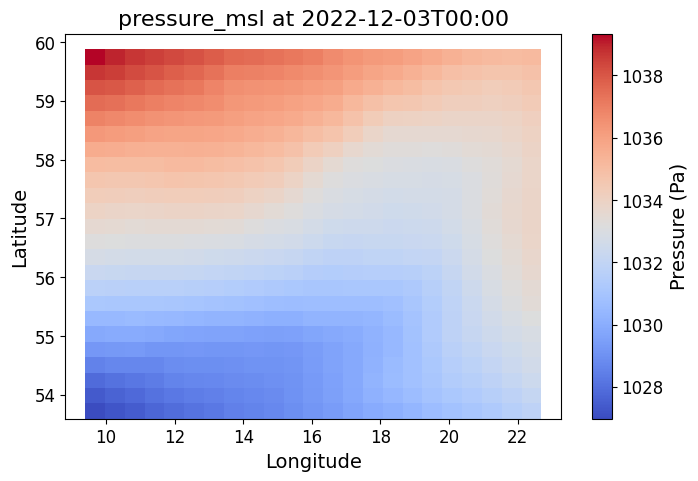

In [10]:

idx = 0
plot_xarray(ds_combined, 'sla', time_idx=idx, cmap='viridis', cbar_label='SLA (m)')
plot_xarray(ds_combined, 'pressure_msl', time_idx=idx, cmap='coolwarm', cbar_label='Pressure (Pa)')

In [11]:
dd

NameError: name 'dd' is not defined

In [ ]:
ds_combined

<xarray.Dataset> Size: 53MB
Dimensions:           (time: 20161, latitude: 5, longitude: 5)
Coordinates:
  * time              (time) datetime64[ns] 161kB 2022-12-03 ... 2025-03-22
  * latitude          (latitude) float64 40B 53.72 55.3 56.87 58.44 60.01
  * longitude         (longitude) float64 40B 9.097 12.57 16.04 19.51 22.99
Data variables: (12/13)
    bottomT           (time, latitude, longitude) float64 4MB 9.999e+03 ... 1...
    sla               (time, latitude, longitude) float64 4MB 9.999e+03 ... -...
    so                (time, latitude, longitude) float64 4MB 9.999e+03 ... 3...
    sob               (time, latitude, longitude) float64 4MB 9.999e+03 ... 4...
    thetao            (time, latitude, longitude) float64 4MB 9.999e+03 ... 1.52
    uo                (time, latitude, longitude) float64 4MB 9.999e+03 ... -...
    ...                ...
    wo                (time, latitude, longitude) float64 4MB 9.999e+03 ... 1...
    pressure_msl      (time, latitude, longitude) float64 4MB 9.999e+03 ... 9...
    surface_pressure  (time, latitude, longitude) float64 4MB 9.999e+03 ... 9...
    wind_gusts_10m    (time, latitude, longitude) float64 4MB 9.999e+03 ... 9...
    wind_u            (time, latitude, longitude) float64 4MB 9.999e+03 ... 9...
    wind_v            (time, latitude, longitude) float64 4MB 9.999e+03 ... 9...

In [ ]:
df_insitu.rename(columns={'slev': 'y'}, inplace=True)

# calculate the lagged values for the insitu data
# calculate laggs
def calculate_lags(df:pd.DataFrame, lags):
    for lag in lags:
        df[f'y_lag_{lag}'] = df['y'].shift(lag)
    return df

y_df_lagged = calculate_lags(df_insitu, lags=[i for i in range(1, HORIZON + 1, 3)])

y_df_lagged.dropna(inplace=True)


# convert df to xarray
y_df_lagged = y_df_lagged.set_index('time', drop=True).to_xarray()
y_df_lagged


<xarray.Dataset> Size: 5MB
Dimensions:    (time: 19995)
Coordinates:
  * time       (time) datetime64[ns] 160kB 2022-12-09T22:00:00 ... 2025-03-22
Data variables: (12/57)
    y          (time) float32 80kB -0.13 -0.1326 -0.1488 ... 0.5383 0.55 0.55
    y_lag_1    (time) float32 80kB -0.1245 -0.13 -0.1326 ... 0.4967 0.5383 0.55
    y_lag_4    (time) float32 80kB -0.004606 -0.04062 -0.08886 ... 0.42 0.4833
    y_lag_7    (time) float32 80kB 0.05531 0.04051 0.02413 ... 0.2317 0.275
    y_lag_10   (time) float32 80kB -0.004259 0.001323 0.04282 ... 0.3017 0.2783
    y_lag_13   (time) float32 80kB -0.08146 -0.04811 -0.03136 ... 0.38 0.3633
    ...         ...
    y_lag_151  (time) float32 80kB 0.2608 0.1513 0.1828 ... 0.03 -0.01167
    y_lag_154  (time) float32 80kB 0.3374 0.3322 0.3455 ... 0.12 0.1017 0.06
    y_lag_157  (time) float32 80kB 0.2295 0.2562 0.2787 ... 0.1867 0.17 0.1467
    y_lag_160  (time) float32 80kB 0.1238 0.1148 0.1433 ... 0.24 0.2383 0.215
    y_lag_163  (time) float32 80kB 0.2851 0.2388 0.1909 ... 0.2017 0.2367 0.24
    y_lag_166  (time) float32 80kB 0.4871 0.4636 0.3739 ... 0.08 0.1083 0.16

In [ ]:
# 1. Gemeinsame Zeitstempel
common_time = np.intersect1d(ds_combined.time.values, y_df_lagged.time.values)

# 2. Auswahl
X_ds = ds_combined.sel(time=common_time)
y = y_df_lagged.sel(time=common_time)['y']
y_lagged = y_df_lagged.drop_vars('y').sel(time=common_time)

# 3. In Arrays umwandeln
X = X_ds.to_array().transpose("time", "variable", "latitude", "longitude").values  # Beispiel
y_lagged = y_lagged.to_array().transpose("time", "variable").values
y = y.values  # falls du ein reines Array brauchst

print(f"Shape of X: {X.shape}")          # (time, features, lat, lon)
print(f"Shape of y: {y.shape}")          # (time,)
print(f"Shape of y_lagged: {y_lagged.shape}")  # (time, n_lags)


Shape of X: (19995, 13, 5, 5)
Shape of y: (19995,)
Shape of y_lagged: (19995, 56)


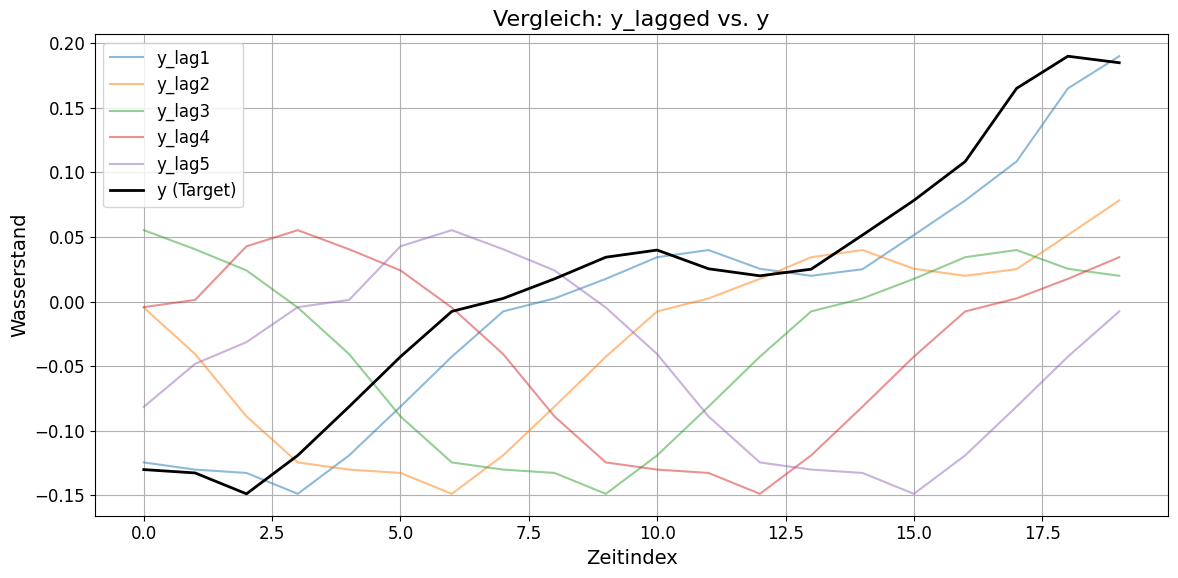

In [ ]:
import matplotlib.pyplot as plt

# Beispiel: Nur ein paar Zeitpunkte zeigen
n_show = 20  # Anzahl der Zeitpunkte zum Plotten

plt.figure(figsize=(12, 6))

# Plot aller Lag-Werte (jeder Lag ist eine Linie)
for lag in range(5):
    plt.plot(y_lagged[:n_show, lag], label=f'y_lag{lag+1}', alpha=0.5)

# Plot der Zielvariable y
plt.plot(y[:n_show], label='y (Target)', linewidth=2, color='black')

plt.legend()
plt.title("Vergleich: y_lagged vs. y")
plt.xlabel("Zeitindex")
plt.ylabel("Wasserstand")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# def add_lagged_y_to_X(X, y, n_lags=1):
#     """
#     Hängt n_lags von y als Feature an X an.
    
#     X: (time, lat, lon, features)
#     y: (time,) oder (time, 1)
    
#     Returns:
#         X_lagged: (time - n_lags, lat, lon, features + n_lags)
#         y_target: (time - n_lags,)
#     """
#     if y.ndim == 2 and y.shape[1] == 1:
#         y = y.squeeze()

#     # Stelle sicher, dass Länge passt
#     T = X.shape[0]
#     assert len(y) == T, "X und y müssen gleiche Zeitlänge haben"

#     # Lagged y erzeugen
#     lagged_features = []
#     for i in range(1, n_lags + 1):
#         lagged = y[:-i]
#         lagged_features.append(lagged[n_lags - i:])  # angleichen an Zielgröße

#     # Shape: (time - n_lags, n_lags)
#     lagged_matrix = np.stack(lagged_features, axis=1)

#     # Broadcast auf (time - n_lags, lat, lon, n_lags)
#     lat, lon = X.shape[1:3]
#     lagged_broadcast = lagged_matrix[:, None, None, :].repeat(lat, axis=1).repeat(lon, axis=2)

#     # Schneide X entsprechend zu
#     X_cut = X[n_lags:]

#     # Concatenieren entlang letzter Achse
#     X_lagged = np.concatenate([X_cut, lagged_broadcast], axis=-1)

#     # Zielwerte anpassen
#     y_target = y[n_lags:]

#     return X_lagged, y_target


# X_lagged, y_target = add_lagged_y_to_X(X, y, n_lags=1)

# print("X_lagged shape:", X_lagged.shape)  # → (time - 3, lat, lon, features + 3)
# print("y_target shape:", y_target.shape)  # → (time - 3,)


In [ ]:
print(y_lagged[:,0])  # Zeige 
print(y[:])

[-0.12445939 -0.13000178 -0.13260014 ...  0.49666667  0.53833336
  0.55      ]
[-0.13000178 -0.13260014 -0.1487727  ...  0.53833336  0.55
  0.55      ]


In [ ]:
X.shape, y.shape  # → (time - 3, lat, lon, features + 3), (time - 3,)

((19995, 13, 5, 5), (19995,))

In [ ]:

def create_sequences(X_data:np.ndarray, y_data:np.ndarray, y_lagged_data, seq_len=168, horizon=168):
    """
    Erzeugt nur Sequenzen, die innerhalb eines zusammenhängenden Bereichs liegen.
    """



    X, y, y_lagged = [], [], []
    for i in range(len(X_data) - seq_len - horizon + 1):
        window_x = X_data[i:i+seq_len+horizon]
        window_y = y_data[i:i+seq_len+horizon]
        window_y_lagged = y_lagged_data[i:i+seq_len+horizon]

        # Sicherheitscheck: Kein NaN und Index ist lückenlos
        if np.any(np.isnan(window_x)) or np.any(np.isnan(window_y)):
            continue  # überspringen
        X.append(window_x[:seq_len])
        y.append(window_y[seq_len:seq_len+horizon])  # z. B. nur Feature 0 als Ziel
        y_lagged.append(window_y_lagged[seq_len:seq_len+horizon])
    return np.array(X), np.array(y), np.array(y_lagged)


X_seq, y_seq, y_lagged_seq = create_sequences(X, y, y_lagged, seq_len=168, horizon=HORIZON)

In [ ]:
X_seq.shape, y_seq.shape, y_lagged_seq.shape  # → (time - 3, lat, lon, features + 3), (time - 3,)

((19660, 168, 13, 5, 5), (19660, 168), (19660, 168, 56))

In [ ]:
train_percentage = 0.8
val_percentage = (1 - train_percentage) / 2
test_percentage = (1 - train_percentage) / 2

print("\nSplitting data into train, validation and test sets...")
print(f"Train: {round(train_percentage*100, 3)}%, Validation: {round(val_percentage*100, 3)}%, Test: {round(test_percentage*100,3)}%")

X_seq_train = X_seq[:int(train_percentage * len(X_seq))] # 50% für Training
X_seq_val = X_seq[int(train_percentage * len(X_seq)):int((train_percentage + val_percentage) * len(X_seq))]  # 20% für Validierung
X_seq_test = X_seq[int((train_percentage + val_percentage) * len(X_seq)):]  # 30% für Test

y_lagged_seq_train = y_lagged_seq[:int(train_percentage * len(y_lagged_seq))]  # 50% für Training
y_lagged_seq_val = y_lagged_seq[int(train_percentage * len(y_lagged_seq)):int((train_percentage + val_percentage) * len(y_lagged_seq))]  # 20% für Validierung
y_lagged_seq_test = y_lagged_seq[int((train_percentage + val_percentage) * len(y_lagged_seq)):]  # 30% für Test

y_seq_train = y_seq[:int(train_percentage * len(y_seq))]  # 50% für Training
y_seq_val = y_seq[int(train_percentage * len(y_seq)):int((train_percentage + val_percentage) * len(y_seq))]  # 20% für Validierung
y_seq_test = y_seq[int((train_percentage + val_percentage) * len(y_seq)):]  # 30% für Test

print("\nShapes of the split datasets:")
print("X_train shape:", X_seq_train.shape, "y_lagged_seq_train shape:", y_lagged_seq_train.shape)
print("X_val shape:", X_seq_val.shape, "y_lagged_seq_val shape:", y_lagged_seq_val.shape)
print("X_test shape:", X_seq_test.shape, "y_lagged_seq_test shape:", y_lagged_seq_test.shape)
print()
print("y_train shape:", y_seq_train.shape)
print("y_val shape:", y_seq_val.shape)
print("y_test shape:", y_seq_test.shape)



Splitting data into train, validation and test sets...
Train: 80.0%, Validation: 10.0%, Test: 10.0%

Shapes of the split datasets:
X_train shape: (15728, 168, 13, 5, 5) y_lagged_seq_train shape: (15728, 168, 56)
X_val shape: (1966, 168, 13, 5, 5) y_lagged_seq_val shape: (1966, 168, 56)
X_test shape: (1966, 168, 13, 5, 5) y_lagged_seq_test shape: (1966, 168, 56)

y_train shape: (15728, 168)
y_val shape: (1966, 168)
y_test shape: (1966, 168)


In [ ]:


# Initialisiere leeres Array für das Ergebnis
X_train_scaled = np.empty_like(X_seq_train)
scaler = StandardScaler()

# Skaliere jedes Feature einzeln über alle Zeit/Lat/Lon
for i in tqdm(range(X_seq_train.shape[-1]), desc="Scaling Training features"):
    feature = X_seq_train[..., i].reshape(-1, 1)  # (samples, 1)
    X_train_scaled[..., i] = scaler.fit_transform(feature).reshape(X_train_scaled[..., i].shape)

# scale lagged values
y_lagged_seq_train_scaled = np.empty_like(y_lagged_seq_train)
for i in tqdm(range(y_lagged_seq_train.shape[-1]), desc="Scaling Training lagged values"):
    feature = y_lagged_seq_train[..., i].reshape(-1, 1)  # (samples, 1)
    y_lagged_seq_train_scaled[..., i] = scaler.fit_transform(feature).reshape(y_lagged_seq_train_scaled[..., i].shape)





# Für Validation/Test: gleiche Skalierung verwenden
X_val_scaled = np.empty_like(X_seq_val)
X_test_scaled = np.empty_like(X_seq_test)
for i in tqdm(range(X_seq_train.shape[-1]), desc="Scaling Validation and Test features"):
    X_val_scaled[..., i] = scaler.transform(X_seq_val[..., i].reshape(-1, 1)).reshape(X_val_scaled[..., i].shape)
    X_test_scaled[..., i] = scaler.transform(X_seq_test[..., i].reshape(-1, 1)).reshape(X_test_scaled[..., i].shape)


# scale lagged values
y_lagged_seq_val_scaled = np.empty_like(y_lagged_seq_val)
y_lagged_seq_test_scaled = np.empty_like(y_lagged_seq_test)
for i in tqdm(range(y_lagged_seq_train.shape[-1]), desc="Scaling Validation and Test lagged values"):
    y_lagged_seq_val_scaled[..., i] = scaler.transform(y_lagged_seq_val[..., i].reshape(-1, 1)).reshape(y_lagged_seq_val_scaled[..., i].shape)
    y_lagged_seq_test_scaled[..., i] = scaler.transform(y_lagged_seq_test[..., i].reshape(-1, 1)).reshape(y_lagged_seq_test_scaled[..., i].shape)

Scaling Validation and Test lagged values: 100%|██████████| 56/56 [00:00<00:00, 71.04it/s]


In [ ]:
# Convert to tensor

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_lagged_train_tensor = torch.tensor(y_lagged_seq_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_seq_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_lagged_val_tensor = torch.tensor(y_lagged_seq_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_seq_val, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_lagged_test_tensor = torch.tensor(y_lagged_seq_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_seq_test, dtype=torch.float32)

print("\nShapes of training tensors:")
print("X_train_tensor shape:", X_train_tensor.shape)
print("y_lagged_train_tensor shape:", y_lagged_train_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)
print("\nShapes of validation tensors:")
print("X_val_tensor shape:", X_val_tensor.shape)
print("y_lagged_val_tensor shape:", y_lagged_val_tensor.shape)
print("y_val_tensor shape:", y_val_tensor.shape)
print("\nShapes of test tensors:")
print("X_test_tensor shape:", X_test_tensor.shape)
print("y_lagged_test_tensor shape:", y_lagged_test_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)


Shapes of training tensors:
X_train_tensor shape: torch.Size([15728, 168, 13, 5, 5])
y_lagged_train_tensor shape: torch.Size([15728, 168, 56])
y_train_tensor shape: torch.Size([15728, 168])

Shapes of validation tensors:
X_val_tensor shape: torch.Size([1966, 168, 13, 5, 5])
y_lagged_val_tensor shape: torch.Size([1966, 168, 56])
y_val_tensor shape: torch.Size([1966, 168])

Shapes of test tensors:
X_test_tensor shape: torch.Size([1966, 168, 13, 5, 5])
y_lagged_test_tensor shape: torch.Size([1966, 168, 56])
y_test_tensor shape: torch.Size([1966, 168])
